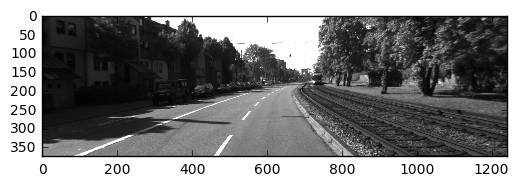

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

camera_sample = './lidar_topview_data/0000000001.png'

camera_img = mpimg.imread(camera_sample)
plt.imshow(camera_img, cmap='gray')

Plotting image


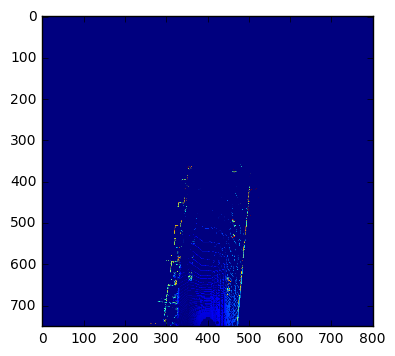

In [2]:
import struct
import numpy as np
import pandas as pd

# Left and Right Limits (in meters). Other points ignored
SIDE_RANGE = (-80, 80)
# Back and Front Limits (in meters). Other points ignored
FWD_RANGE = (0, 150)
# Rescale the images (Super resolution)
RES = 0.2

def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)


def crop_lidar(df, side_range, fwd_range):
    """
    Selecting specific LIDAR region
    :param df: LIDAR data in Dataframe format
    :param side_range: left-most to right-most in meters
    :param fwd_range: back-most to forward-most in meters
    :return: Modified Dataframe with only indices of points within desired cube
    """
    # Note left side is positive y axis in LIDAR coordinates
    f_filt = np.logical_and((df['x'] > fwd_range[0]), (df['x'] < fwd_range[1]))
    s_filt = np.logical_and((df['y'] > -side_range[1]), (df['y'] < -side_range[0]))
    filter = np.logical_and(f_filt, s_filt)
    indices = np.argwhere(filter).flatten()
    return df.loc[indices, :]


def clip_height(z, height_range):
    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a=z,
                           a_min=height_range[0],
                           a_max=height_range[1])

    # Rescale height to range 0-255
    pixel_values = scale_to_255(pixel_values, min=height_range[0], max=height_range[1])
    return pixel_values


def rescale_lidar(df, side_range, fwd_range, res):
    x_points = df['x']
    y_points = df['y']

    df['x'] = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    df['y'] = (-x_points / res).astype(np.int32)  # y axis is -x in LIDAR

    # Shifting to new origin
    df['x'] -= int(np.floor(side_range[0] / res))
    df['y'] += int(np.ceil(fwd_range[1] / res))
    return df


def transform_labels(df, side_range, fwd_range, res):
    x_points = df['tx']
    y_points = df['ty']
    df['w'] = (df['w'] / res).astype(np.int32)
    df['l'] = (df['l'] / res).astype(np.int32)

    df['tx'] = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    df['ty'] = (-x_points / res).astype(np.int32)  # y axis is -x in LIDAR

    # Shifting to new origin
    df['tx'] -= int(np.floor(side_range[0] / res))
    df['ty'] += int(np.ceil(fwd_range[1] / res))
    return df


def rescale_inverse(points, side_range, fwd_range, res):
    x = points[0]
    y = points[1]

    # Shifting to new origin
    x += int(np.floor(side_range[0] / res))
    y -= int(np.ceil(fwd_range[1] / res))

    x_point = (-y * res)  # x axis is -y in LIDAR
    y_point = (-x * res)  # y axis is -x in LIDAR
    return (x_point, y_point)

def read_bin_file(filename):
    f = open(filename, 'rb')
    data = []
    while True:
        b = f.read(4)
        if not b:
            break
        v = struct.unpack('f', b)
        data.append(v)

    data = np.array(data)
    data = np.reshape(data, (-1, 4))

    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    r = data[:, 3]

    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['z'] = z
    df['r'] = r
    return df

def generate_top_view(df, side_range, fwd_range, res):
    # Crop ROI using limits ^^^.
    df_roi_cropped = crop_lidar(df, side_range, fwd_range)

    df_roi = rescale_lidar(df_roi_cropped.copy(), side_range, fwd_range, res)

    # Clip the height
    # height = (-2, 0.5)  # RONNY DEFAULT
    height = (-2, 2)  # bottom-most to upper-most
    pixel_values = clip_height(df_roi['z'], height)

    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = 1 + int((side_range[1] - side_range[0]) / res)
    y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    im[df_roi['y'], df_roi['x']] = pixel_values
    return (im, df_roi)



def read_labels():
    labels = pd.read_csv('./lidar_topview_data/labels.csv')
    labels.drop(labels.columns[[0]], axis=1, inplace=True)
    # Left and Right Limits (in meters). Other points ignored
    side_range = (-80, 80)
    # Back and Front Limits (in meters). Other points ignored
    fwd_range = (0, 150)
    # Rescale the images (Super resolution)
    res = 0.01

    labels['max_side'] = labels[['l', 'w']].max(axis=1) * 1.5
    labels['xmin'] = labels['tx'] - (labels['max_side'] / 2.0)
    labels['xmax'] = labels['tx'] + (labels['max_side'] / 2.0)
    labels['ymin'] = labels['ty'] - (labels['max_side'] / 2.0)
    labels['ymax'] = labels['ty'] + (labels['max_side'] / 2.0)
    return labels

def plot_bin_file(bin_file_path):
    df = read_bin_file(bin_file_path)
    (image, df_roi) = generate_top_view(df, SIDE_RANGE, FWD_RANGE, RES)

    print("Plotting image")
    %matplotlib inline
    plt.imshow(image)
    return image
    
lidar_image = plot_bin_file('./lidar_topview_data/0000000001.bin')
labels = read_labels()

In [3]:
labels_path = './lidar_topview_data/labels.csv'
labels = pd.read_csv(labels_path)

In [4]:
labels

,Unnamed: 0,drive,frame,object,h,w,l,tx,ty,tz,...,rz,state,occlusion,occlusion_kf,truncation,amt_occlusion,amt_occlusion_kf,amt_border_l,amt_border_r,amt_border_kf
0,0,1,0.0,Car,2.167235,1.705712,4.329356,25.212516,8.603392,-1.792157,...,-3.184200,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1.0
1,1,1,1.0,Car,2.167235,1.705712,4.329356,23.865835,8.638552,-1.827676,...,-3.184200,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
2,2,1,2.0,Car,2.167235,1.705712,4.329356,22.475106,8.675590,-1.863800,...,-3.184200,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
3,3,1,3.0,Car,2.167235,1.705712,4.329356,21.109089,8.720640,-1.865978,...,-3.182645,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
4,4,1,4.0,Car,2.167235,1.705712,4.329356,19.743072,8.765690,-1.868156,...,-3.181090,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
5,5,1,5.0,Car,2.167235,1.705712,4.329356,18.377054,8.810739,-1.870334,...,-3.179535,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
6,6,1,6.0,Car,2.167235,1.705712,4.329356,17.011037,8.855789,-1.872512,...,-3.177980,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
7,7,1,7.0,Car,2.167235,1.705712,4.329356,15.693185,8.902236,-1.870445,...,-3.174540,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
8,8,1,8.0,Car,2.167235,1.705712,4.329356,14.375333,8.948683,-1.868377,...,-3.171101,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
9,9,1,9.0,Car,2.167235,1.705712,4.329356,13.057481,8.995131,-1.866310,...,-3.167662,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.0


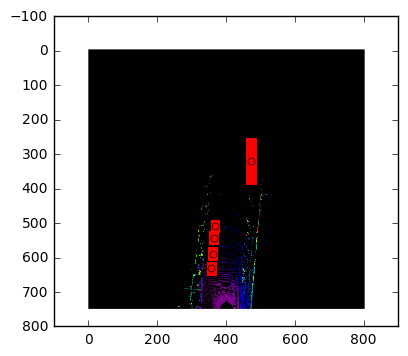

In [21]:
import matplotlib.patches as patches

def drawBB(lidar_image, frame_labels):
    fig,ax = plt.subplots(1)
    ax.imshow(lidar_image, cmap="spectral", vmin=0, vmax=255)

    for i in range(len(frame_labels)):
        x = frame_labels['tx'].iloc[i]
        y = frame_labels['ty'].iloc[i]
        w = frame_labels['w'].iloc[i]
        l = frame_labels['l'].iloc[i]
        plt.plot(x, y, 'ro', markersize=5)
        ax.add_patch(
            patches.Rectangle(
                (x - (w/2),y - (l/2)),
                w,  # width
                l,  # height
                linewidth=5,
                edgecolor='r'
            )
        )
    plt.show()
    
current_frame_labels = labels.loc[(labels.drive == 1) & (labels.frame == 1)].copy()
current_frame_labels = transform_labels(current_frame_labels, SIDE_RANGE, FWD_RANGE, RES)
drawBB(lidar_image, current_frame_labels)